## А/А-тестирование мобильного приложения. 

Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

Входные данные:  
- experimentVariant – вариант эксперимента;
- version – версия приложения;
- purchase – факт покупки

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [3]:
app = pd.read_csv('./hw_aa.csv', sep=';')

In [4]:
app

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [5]:
app.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [6]:
# оценим объем экспериментальных вариантов
app.experimentVariant.value_counts() 

1    63916
0    63102
Name: experimentVariant, dtype: int64

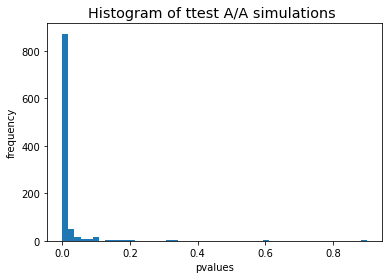

0.933

In [8]:
simulations = 1000 # количество симуляций
n_s = 1000 # размер подвыборки
res_app = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    group1 = app[app.experimentVariant == 0].sample(n_s, replace = False).purchase
    group2 = app[app.experimentVariant == 1].sample(n_s, replace = False).purchase
    res_app.append(stats.ttest_ind(group1, group2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res_app, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res_app) <0.05) / simulations

**При запуске АА-теста FPR = 0.933, что больше уровня альфа.**

## Попробуем найти причины поломки сплит-системы

In [9]:
#оценим МП по количеству покупок
app.query('purchase == 1').groupby(['experimentVariant', 'version']).agg({'purchase': 'count'})

purchase
experimentVariant version           
0                 v2.8.0          41
                  v2.9.0         890
                  v3.7.4.0       252
                  v3.8.0.0       328
1                 v2.8.0        1895
                  v2.9.0         858
                  v3.7.4.0       266
                  v3.8.0.0       384

Заметно что в 0 варианте v2.8.0 совершалось меньше покупок, чем в 1 варианте

In [10]:
#Посчитаем конверсию (коэффициент покупок)
app.groupby(['experimentVariant', 'version'])\
    .agg({'purchase': 'mean'})\
    .rename(columns={'purchase': 'conversation_rate'})

conversation_rate
experimentVariant version                    
0                 v2.8.0             0.000993
                  v2.9.0             0.074658
                  v3.7.4.0           0.059943
                  v3.8.0.0           0.057604
1                 v2.8.0             0.045606
                  v2.9.0             0.071304
                  v3.7.4.0           0.063018
                  v3.8.0.0           0.062848

__Вывод:__

При рассчете конверсии выявлено, что в экспериментальном варианте №0 в версии приложения 2.8.0 покупатели делали значительно меньше покупок(0.000993), чем в этой же версии в экспериментальном варианте №1(0.045606). Вероятно такие сильные различия в группах и повлияли на результаты работы сплит-системы

### Для подтверждения нашей гипотезы, сравним гистограммы распределений p-value для каждой версии мобильного приложения

In [11]:
app.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [12]:
def check_split(app_test):
    simulations = 1000
    n_s = 1000
    res_app_t = []
    
    for i in tqdm(range(simulations)):
        group_t1 = app_test[app_test.experimentVariant == 0].sample(n_s, replace = False).purchase
        group_t2 = app_test[app_test.experimentVariant == 1].sample(n_s, replace = False).purchase
        res_app_t.append(stats.ttest_ind(group_t1, group_t2, equal_var = False)[1]) 


    plt.hist(res_app_t, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    return sum(np.array(res_app_t) <0.05) / simulations

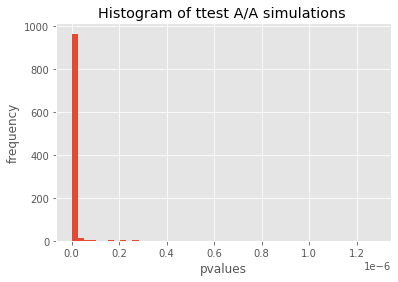

1.0

In [13]:
check_split(app.query('version == "v2.8.0"'))

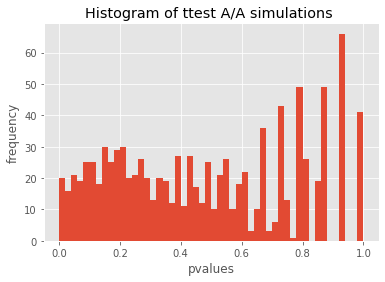

0.046

In [14]:
check_split(app.query('version == "v2.9.0"'))

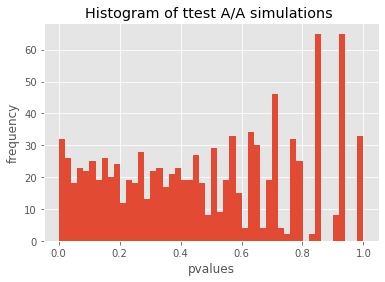

0.063

In [15]:
check_split(app.query('version == "v3.8.0.0"'))

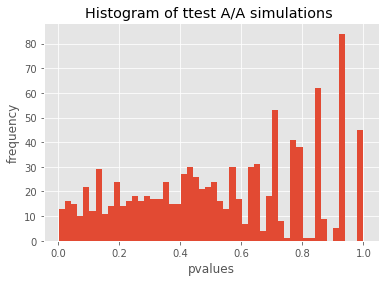

0.039

In [16]:
check_split(app.query('version == "v3.7.4.0"'))

При сравнении гистограмм для каждой версии МП были получены следующие результаты:

- у версии v2.9.0, v3.7.4.0 : FPR < 0.05 

- у версии v3.8.0.0: FPR = 0.067, можно использовать в общей выборке
    
- у версии v2.8.0 FPR  = 1.0, что говорит нам о том, что в 100% p-value<0.05 и выборочные средние в 2х группах(вариант 0 и вариант 1) различаются статистически значимо
    
    
## Проведем АА-тестирование без учета МП v2.8.0 и оценим полученные результаты

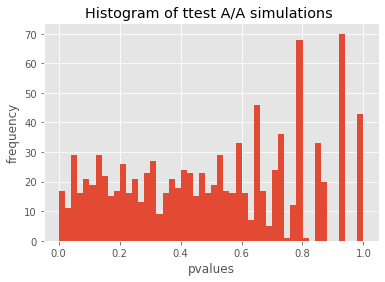

0.037

In [19]:
check_split(app.query('version != "v2.8.0" '))

Полученная гистограмма позволяет сделать вывод, что значение p-value распространено относительно равномерно. При проверке системы сплитования было установлено, что в ~4% случаях p-value меньше или равно заданному порогу альфа 0.05, таким образом теперь система сплитования работает корректно.